In [ ]:
### Imports

In [1]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath


# Firefly client imports
from IPython.display import IFrame

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

In [3]:
import eups
assert eups.getSetupVersion("obs_lsst")

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [4]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False
isr_config.doSaturationInterpolation=False

### Construct the `IsrTask` with the above configuration

In [5]:
isr = IsrTask(config=isr_config)

### Setup firefly to do image visualization

In [6]:
my_channel = '{}_isr_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

In [91]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})
gain = {}
exp_time = {}
sumim_mean = {}

i = 1
for visit1, visit2 in zip(visits[:-1:2], visits[1::2]): # loop over pairs of images
    # Get ISR data for first image
    dId = {'visit': visit1, 'detector': 2}
    raw1 = butler.get('raw', **dId)
    bias1 = butler.get('bias', **dId)
    time1 = raw1.getInfo().getVisitInfo().getExposureTime()
    
    # Get ISR data for second image
    dId = {'visit': visit2, 'detector': 2}
    raw2 = butler.get('raw', **dId)
    bias2 = butler.get('bias', **dId)
    time2 = raw2.getInfo().getVisitInfo().getExposureTime()
    if abs(time1 - time2) > 0.01:
        "Mismatched exptimes"
        continue
    
    # run ISR on both images
    result1 = isr.run(raw1, bias=bias1)
    result2 = isr.run(raw2, bias=bias2)
    
    detector = result1.exposure.getDetector()
    amp = detector[3]

    sub_im1 = result1.exposure.getMaskedImage()[amp.getBBox()]
    #arr1 = sub_im1.getImage().getArray()
    sub_im2 = result2.exposure.getMaskedImage()[amp.getBBox()]
    #arr2 = sub_im2.getImage().getArray()
    
    # From RHL, 1/g = <(I1-I2)**2/(I1+I2)>
    diff_im = sub_im1.clone()
    diff_im -= sub_im2
    
    sum_im = sub_im1.clone()
    sum_im += sub_im2
    
    diff_im *= diff_im
    diff_im /= sum_im
    
    stats = afwMath.makeStatistics(diff_im, afwMath.MEDIAN | afwMath.MEAN)
    sumim_stats = afwMath.makeStatistics(sum_im, afwMath.MEDIAN | afwMath.MEAN)
    
    # Compute gain for this amp.
    gain[visit1] = 1/stats.getValue(afwMath.MEAN)
    sumim_mean[visit1] = sumim_stats.getValue(afwMath.MEAN)
    exp_time[visit1] = time1
    print("visit %i,%i -- %i of %i -- gain=%f, exposure time(s)=%f"%(visit1, visit2, i, len(visits)/2, gain[visit1], exp_time[visit1], ))
    i += 1

visit 258339739,258339769 -- 1 of 39 -- gain=0.505830, exposure time(s)=0.088000
visit 258339807,258339839 -- 2 of 39 -- gain=0.520910, exposure time(s)=0.115000
visit 258339875,258339908 -- 3 of 39 -- gain=0.573624, exposure time(s)=0.160000
visit 258339945,258339976 -- 4 of 39 -- gain=0.597037, exposure time(s)=0.213000
visit 258340014,258340047 -- 5 of 39 -- gain=0.620209, exposure time(s)=0.284000
visit 258340086,258340120 -- 6 of 39 -- gain=0.639889, exposure time(s)=0.498000
visit 258340159,258340176 -- 7 of 39 -- gain=0.649814, exposure time(s)=0.667000
visit 258340202,258340220 -- 8 of 39 -- gain=0.650776, exposure time(s)=0.889000
visit 258340244,258340265 -- 9 of 39 -- gain=0.632029, exposure time(s)=1.156000
visit 258340290,258340314 -- 10 of 39 -- gain=0.665427, exposure time(s)=1.601000
visit 258340341,258340363 -- 11 of 39 -- gain=0.394879, exposure time(s)=2.135000
visit 258340392,258340416 -- 12 of 39 -- gain=0.674312, exposure time(s)=2.847000
visit 258340449,258340477

In [8]:
afw_display.mtv(sub_im1) # display an example image

In [94]:
visit_keys = exp_time.keys()
x = [exp_time[visit] for visit in visit_keys]
y = [gain[visit] for visit in visit_keys]
signal = [sumim_mean[visit] for visit in visit_keys]

(0, 1)

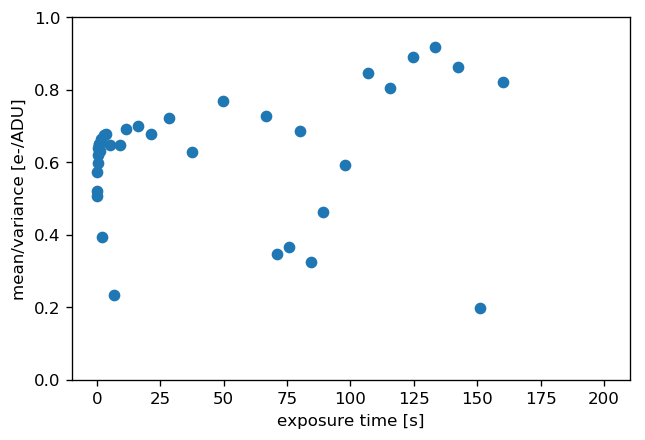

In [104]:
plt.scatter(x, y)
#plt.xscale('log')
plt.xlabel('exposure time [s]')
plt.ylabel('mean/variance [e-/ADU]')
plt.ylim(0, 1)

this gain vs. exposure time appears to be weird. import externally evaluated results drawn from the same data set (RTM-007, run_id=7086, S02, C13) for the 39 image pairs to investigate.

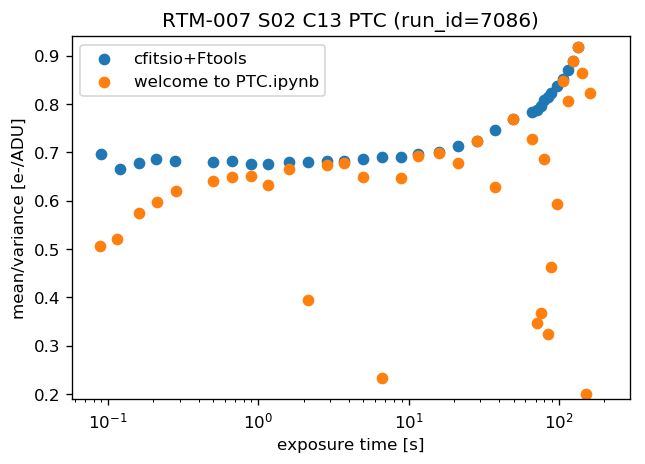

In [105]:
# Generate acomparison plot for (mean/variance) vs. exposure time
external_work_file='/project/arasmus/RTM-007_ptc/RTM007_S02_C13_one_over_gain.qdp'
data=numpy.loadtxt(external_work_file,skiprows=2)
expotime=data[:,0]
e_per_adu=data[:,2]
plt.scatter(expotime, e_per_adu, label='cfitsio+Ftools')
plt.scatter(x,y,label='welcome to PTC.ipynb')
plt.xscale('log')
plt.xlabel('exposure time [s]')
plt.ylabel('mean/variance [e-/ADU]')
plt.ylim(0.19, 0.94)
plt.title('RTM-007 S02 C13 PTC (run_id=7086)')
plt.legend()

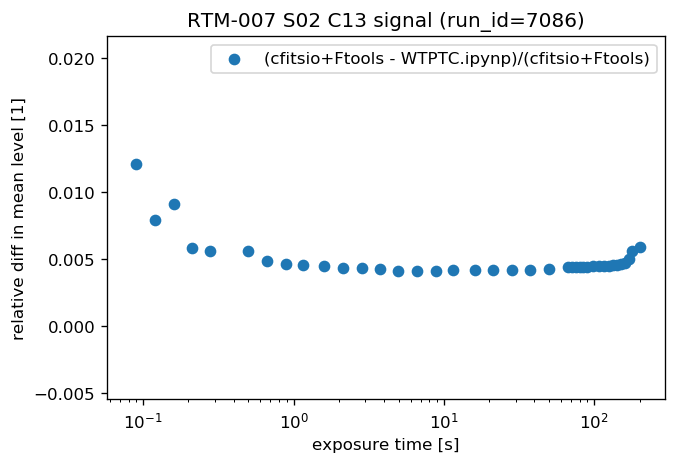

In [109]:
# generate a normalized difference for the mean of the flat pair sum vs. exposure time
external_raw_file='/project/arasmus/RTM-007_ptc/Corr_[3].qdp'
means=numpy.loadtxt(external_raw_file,skiprows=1)
mean=means[:,0]
signal_diff=(mean-signal)/mean
plt.scatter(expotime, signal_diff, label='(cfitsio+Ftools - WTPTC.ipynp)/(cfitsio+Ftools)')
plt.xscale('log')
plt.xlabel('exposure time [s]')
plt.ylabel('relative diff in mean level [1]')
# plt.ylim(0.19, 0.94)
plt.title('RTM-007 S02 C13 signal (run_id=7086)')
plt.legend()

In [11]:
i=1
for visit1,visit2 in zip(visits[:-1:2],visits[1::2]):
    # first of pair
    dId1 = {'visit': visit1, 'detector': 2}
    raw1 = butler.get('raw', **dId1)
    bias1 = butler.get('bias', **dId1)
    time1 = raw1.getInfo().getVisitInfo().getExposureTime()
    # second of pair
    dId2 = {'visit': visit1, 'detector': 2}
    raw2 = butler.get('raw', **dId2)
    bias2 = butler.get('bias', **dId2)
    time2 = raw2.getInfo().getVisitInfo().getExposureTime()
    # check for exposure times.
    if abs(time1 - time2) > 0.001:
        "Mismatched exptimes"
        continue
    # run ISR on both images
    signal1 = isr.run(raw1, bias=bias1)
    signal2 = isr.run(raw2, bias=bias2)
    
    bbox = signal1.exposure.getDetector()[3].getBBox()
    
    sub_im1 = signal1.exposure.getMaskedImage()[bbox]
    #arr1 = sub_im1.getImage().getArray()
    sub_im2 = signal2.exposure.getMaskedImage()[bbox]
    #arr2 = sub_im2.getImage().getArray()

    # define the Bounding Box: amplifier 3
    
    print ("ix {}, im1 {}, {}, im2 {}, {}".format(i,visit1,time1,visit2,time2))
    i +=1

ix 1, im1 258339739, 0.088, im2 258339769, 0.088
ix 2, im1 258339807, 0.115, im2 258339839, 0.115
ix 3, im1 258339875, 0.16, im2 258339908, 0.16
ix 4, im1 258339945, 0.213, im2 258339976, 0.213
ix 5, im1 258340014, 0.284, im2 258340047, 0.284
ix 6, im1 258340086, 0.498, im2 258340120, 0.498
ix 7, im1 258340159, 0.667, im2 258340176, 0.667
ix 8, im1 258340202, 0.889, im2 258340220, 0.889
ix 9, im1 258340244, 1.156, im2 258340265, 1.156
ix 10, im1 258340290, 1.601, im2 258340314, 1.601
ix 11, im1 258340341, 2.135, im2 258340363, 2.135
ix 12, im1 258340392, 2.847, im2 258340416, 2.847
ix 13, im1 258340449, 3.737, im2 258340477, 3.737
ix 14, im1 258340511, 4.982, im2 258340542, 4.982
ix 15, im1 258340581, 6.673, im2 258340618, 6.673
ix 16, im1 258340662, 8.897, im2 258340707, 8.897
ix 17, im1 258340758, 11.567, im2 258340811, 11.567
ix 18, im1 258340873, 16.016, im2 258340939, 16.016
ix 19, im1 258341017, 21.354, im2 258341101, 21.354
ix 20, im1 258341198, 28.473, im2 258341305, 28.473
ix 

In [ ]:
# plot mean vs. exposure time


In [53]:
raw_arb = butler.get('raw', {'visit': visits[10], 'detector': 0})
bias_arb = butler.get('bias', {'visit': visits[10], 'detector': 0})
# run ISR on both images
result_arb = isr.run(raw_arb, bias=bias_arb)
detector_arb = result_arb.exposure.getDetector()
amp_arb = detector_arb['C13']
amp_arb.getBBox()
amp_arb.getName()

'C13'